<a href="https://colab.research.google.com/github/OREL-group/GSoC/blob/main/Open%20Source%20Ethics/Collective%20Cognition%20(AI%20Ethics)/Simulation_Run_for_an_Active_Inference_Model_of_Collective_Intelligence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# *An Adaptation of* an Active Inference Model of Collective Intelligence
#### Originally by Rafael Kaufmann, Pranav Gupta, and Jacob Taylor
Corresponding author: jacob.taylor@anthro.ox.ac.uk
- Paper reporting results and the larger framework currently under review
- The base model implements AIF in a simplified sensory environment as explained in [McGregor et al. 2015](https://arxiv.org/abs/1503.04187)

### *Adapted by Brian McCorkle for [Orthogonal Research and Education Laboratory](https://orthogonal-research.weebly.com/) for [INCF](https://www.incf.org/) as part of [Google Summer of Code](https://summerofcode.withgoogle.com/)*

## Setup

### Imports

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime

from matplotlib import pyplot as plt
pd.options.display.float_format = '{:20,.4f}'.format
import seaborn as sns
sns.set_style("whitegrid")

### Helper Functions

The original model Kaufmann et al proposed was based on a one-dimensional circular environment with predefined targets adapted from [McGregor et al](https://www.researchgate.net/publication/273640094_A_Minimal_Active_Inference_Agent).

In [2]:
# Helper Functions

def model_encoding(b):
  """
  Probability of occupying specific position as encoded in the internal state.
  """
  return softmax(b)

def model_encoding_derivative(b):
  """
  Derivative of the model encoding for free energy gradient calculation
  """
  return D_softmax(model_encoding(b))

def variational_density(b):
  """
  P(psi | b)
  Agent's belief about the external states (i.e. its current position in the 
  world) or intention (i.e. desired position in the world) as encoded in the
  internal state.
  """
  return model_encoding(b)

def logdiff(p1, p2):
  return (np.log(p1) - np.log(p2))

def KLv(p1, p2):
  return np.multiply(p1, logdiff(p1, p2))

def KL(p1, p2):
  """
  Kullback-Leibler divergence between densities 1 and 2.
  """
  return np.sum(KLv(p1, p2))

def softmax(b):
  # Softmax function. The shift by b.max() is for numerical stability
  sum = np.sum(np.exp(b - b.max()))
  return np.exp(b - b.max()) / sum

def D_softmax(q):
  # Gradient of softmax function
  return np.diag(q) - np.outer(q, q)

def rerange(q, a):
  return a * q + (1-a)/ENV_SIZE

def dynamic_rerange(q):
  B_MIN = -10
  b = np.log(q)
  b -= np.max(b)
  b_hat = np.maximum(b, B_MIN)
  return softmax(b_hat)

def p_action(q):
  # probability of partner action
  p = []
  q_hat = 0.9 * q / np.max(q)
  p.append(q_hat)  # a_p = 0
  A = (1-q_hat) / (np.roll(q, 1) + np.roll(q, -1))
  p.append(np.roll(q, -1) * A)  # a_p = -1
  p.append(np.roll(q, +1) * A)  # a_p = +1
  return np.array(p)

## Agent and Simulation Code

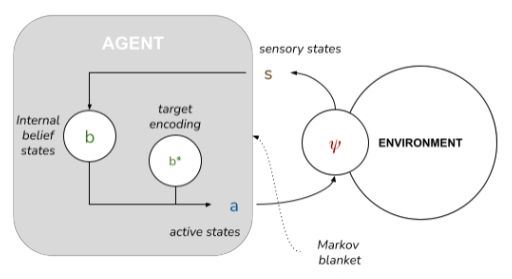

### Agent Class

In [ ]:
# Agent Class: Core Mechanics of AIF with ToM and Alignment

class Agent():
  def __init__(self, psi, b_star, perceptiveness, alterity, alignment):
    # intializations
    self.psi = psi
    self.alterity = alterity
    env = np.array(range(ENV_SIZE))
    self.sensory_dynamics = perceptiveness * np.exp(-SENSE_DECAY_RATE * 
                np.minimum(np.abs(env - int(ENV_SIZE/2)), np.abs(env - int(ENV_SIZE/2) - ENV_SIZE)))
    self.b = (np.zeros(ENV_SIZE), np.zeros(ENV_SIZE))
    self.b_star = (b_star[0] + (1 - alignment) * b_star[1],
                   b_star[0] + (1 - alignment) * b_star[2])
    self.q = (variational_density(self.b[0]), variational_density(self.b[1]))
    self.q_star = (variational_density(self.b_star[0]), variational_density(self.b_star[1]))
    self.p_ap = p_action(self.q_star[1])
    self.a = (0,0)
    self.a_pp = 0           
    self.delta = 0
    
    # logs
    self.psi_trace = [psi]
    self.psi_partner_trace = []
    self.b_own_trace = [self.sensory_dynamics]
    self.b_partner_trace = [self.sensory_dynamics]
    self.s_trace = []
    self.a_trace = []

  def free_energy_own(self, a, p_own, p_partner):
    p_partner_reranged = rerange(p_partner, self.alterity)
    p_partner_shifted = np.roll(p_partner_reranged, self.delta + a[0] - a[1])
    return KL(self.q_star[0], dynamic_rerange(p_own * p_partner_shifted))

  def free_energy_partner(self, a, p_own, p_partner):
    p_own_reranged = rerange(p_own, self.alterity ** 2)
    p_own_shifted = np.roll(p_own_reranged, - (self.delta + a[0] - a[1]))
    return KL(self.q_star[1], dynamic_rerange(p_partner * p_own_shifted))

  def fe_gradient(self, b_prime, p_own, p_partner, delta_prime):
    """
    Partial derivatives of the free energy with respect to belief.
    FE = KL(q_own || p_own * q_partner[-delta]) + KL(q_partner || p_partner * q_own[+delta])
    """
    q_own = variational_density(b_prime[0])
    q_partner = variational_density(b_prime[1])
    p_own_reranged = rerange(p_own, self.alterity ** 2)
    p_partner_reranged = rerange(p_partner, self.alterity)
    p_own_shifted = np.roll(p_own_reranged, -delta_prime)
    p_partner_shifted = np.roll(p_partner_reranged, delta_prime)

    Dq_own = D_softmax(q_own)
    Dq_partner = D_softmax(q_partner)

    v = (1 + logdiff(q_own, dynamic_rerange(p_own * p_partner_shifted)),
         1 + logdiff(q_partner, dynamic_rerange(p_partner * p_own_shifted)))
    
    return np.array([np.dot(Dq_own, v[0]), np.dot(Dq_partner, v[1])])

  def generative_density_own(self, a=(0,0)):
    q_own = self.q[0]
    sd = self.sensory_dynamics if self.s == 1 else 1 - self.sensory_dynamics
    return np.roll(sd * q_own, a[0])
  
  def generative_density_partner(self, a=(0,0)):
    q_own = self.q[0]
    q_partner = self.q[1]

    p_delta = np.roll(q_own, -self.delta)
    p_app = np.roll(self.p_ap[ACTIONS.index(self.a_pp)], -self.a_pp)
    p_j_prior = q_partner
    p_j_posterior = p_delta * p_app * p_j_prior
    return np.roll(p_j_posterior, a[1])

  def step(self):
    # Roll the dice on measuring sensory state s \in {0, 1}
    s = int(np.random.random() < self.sensory_dynamics[self.psi])
    self.s = s

    # Pick action state, a \in {-1, 0, 1}^2 (pair of own and partner actions)
    # Calculate the free energy given my target (intent) distribution, current state distribution, & sensory input 
    # Do this for all (three) actions and select the action with minimum free energy.
    
    fes = []
    epsilon = 0.999 + np.random.random(3)*0.002  # perturb values to randomize the action chosen if equal FE 
    for a in ACTIONS_SQUARED:
      p_own = self.generative_density_own(a)
      p_partner = self.generative_density_partner(a)
      fes.append([self.free_energy_own(a, p_own, p_partner) * epsilon[a[0]+1], 
                  self.free_energy_partner(a, p_own, p_partner)])
    fes_t = np.transpose(fes)
    actions_index = [np.argmin(fes_t[0]), np.argmin(fes_t[1])]
    a = (ACTIONS_SQUARED[actions_index[0]][0], ACTIONS_SQUARED[actions_index[1]][1])
    self.a = a
    delta_prime = self.delta + a[0] - a[1]

    # Update actual (own) position by taking action. Of course, partner action never gets realized
    psi = (self.psi + a[0]) % ENV_SIZE
    self.psi = psi

    p_own = self.generative_density_own()
    p_partner = self.generative_density_partner()
    b_prime = np.array([np.roll(self.b[0], a[0]), np.roll(self.b[1], a[1])])
    
    # Now minimise free energy
    for step in range(N_STEPS):
      b_prime -= LEARNING_RATE * self.fe_gradient(b_prime, np.roll(p_own, a[0]), np.roll(p_partner, a[1]), delta_prime)

    # Save position, sensory output, and internal state for plotting
    self.b = b_prime
    self.q = (variational_density(b_prime[0]), variational_density(b_prime[1]))
    self.s_trace.append(s)
    self.a_trace.append(a[0])
    self.psi_trace.append(psi)
    self.psi_partner_trace.append(psi - self.delta)
    self.b_own_trace.append(model_encoding(b_prime[0]))
    self.b_partner_trace.append(model_encoding(b_prime[1]))

  def plot_traces(self):
    """
    Helper function for plotting agent's internal state and position + agent's beliefs about partner's position.
    """
    # Plot own belief trace
    fig1 = plt.figure(figsize=(15, 4))
    ax = fig1.gca()
    im = ax.imshow(np.transpose(self.b_own_trace),
              interpolation="nearest", 
              aspect = "auto", 
              vmin = 0, vmax = 1, 
              cmap = "viridis")
    c = np.asarray(['white' if s==1 else 'grey' for s in self.s_trace])
    psi = np.asarray(self.psi_trace)
    epochs = np.arange(EPOCHS+1)
    self.a_trace.append(0)
    a = np.asarray(self.a_trace)
    idx = a<0
    ax.scatter(epochs[idx], psi[idx], c = c[idx], marker = 'v')
    idx = a>0
    ax.scatter(epochs[idx], psi[idx], c = c[idx], marker = '^')
    idx = a==0
    ax.scatter(epochs[idx], psi[idx], c = c[idx], marker = 'o')    
    ax.invert_yaxis()
    ax.set_xlim([0,EPOCHS+1])
    fig1.colorbar(im)

    # Then plot partner belief trace
    fig2 = plt.figure(figsize=(15, 4))
    ax = fig2.gca()
    im = ax.imshow(np.transpose(self.b_partner_trace),
              interpolation="nearest", 
              aspect = "auto", 
              vmin = 0, vmax = 1, 
              cmap = "viridis")   
    ax.invert_yaxis()
    ax.set_xlim([0,EPOCHS+1])
    fig2.colorbar(im)

    return fig1, fig2

  def log_convergence(self, targets):
    """
    Helper function to calculate absolute distance from target position.
    """
    psi = np.array(self.psi_trace)
    c0 = np.minimum(np.abs(psi - targets[0]), 
                    np.minimum(np.abs(psi - targets[0] - ENV_SIZE),
                               np.abs(psi - targets[0] + ENV_SIZE)))
    if len(targets) == 1:
      return 'shared target', c0
    
    c1 = np.minimum(np.abs(psi - targets[1]), 
                    np.minimum(np.abs(psi - targets[1] - ENV_SIZE), 
                               np.abs(psi - targets[1] + ENV_SIZE)))
    # return the convergent distance from closest target.
    if c0[-1] <= c1[-1]:
      return 'shared target', c0
    else:
      return 'unshared target', c1

### Simulation Functions

In [ ]:
# Simulation Functions

def simulate_agents(ag):
  """
  Simulate the agents for EPOCHS steps.
  """
  for epoch in range(EPOCHS):
    # Update each agent's perceived delta with their actual delta
    delta = [0, 0]
    delta[0] = ag[0].psi - ag[1].psi
    delta[1] = -delta[0]
    ag[0].delta = delta[0]
    ag[1].delta = delta[1]

    # Update each agent's perceived partner action with their partner's previous action
    ag[0].a_pp = ag[1].a[0]
    ag[1].a_pp = ag[0].a[0]

    for i in range(2):
      ag[i].step()

  # For plotting add target position as probability distribution at the end of the belief trace
  for i in range(2):
    tgt = model_encoding(ag[i].b_star[0])
    ag[i].b_own_trace.append(tgt/tgt.max())
    ag[i].s_trace.append(int(np.random.random() < ag[i].sensory_dynamics[ag[i].psi]))
  return ag

def initialize_b_star(targets, sharpness=6):
  b_star = []
  B_STANDARD = np.array([np.exp(-((i-ENV_SIZE/2)/(ENV_SIZE/sharpness))**2) for i in range(ENV_SIZE)])
  for target in targets:
    b_star.append(np.roll(B_STANDARD, target-ENV_SIZE // 2))
  return b_star

def singleRun(shared_target, perceptiveness, alterity, alignment, plot=False):

  # initialize agents
  initial_positions = [(shared_target + SHORTEST_PATH) % ENV_SIZE,
                       (shared_target - SHORTEST_PATH) % ENV_SIZE]

  target_0 = (shared_target - TARGET_DELTA) % ENV_SIZE
  target_1 = (shared_target + TARGET_DELTA) % ENV_SIZE
  
  b_star_0 = initialize_b_star([shared_target, target_0, target_1])
  b_star_1 = initialize_b_star([shared_target, target_1, target_0])

  # Run simulation
  agents = (Agent(initial_positions[0], b_star_0,
                  perceptiveness[0], alterity[0], alignment),
            Agent(initial_positions[1], b_star_1,
                  perceptiveness[1], alterity[1], alignment))
  agents = simulate_agents(agents)

  # Plot output
  if plot:
    for i in range(2):
      agents[i].plot_traces()
    
  tgt_0, log_0 = agents[0].log_convergence([shared_target, target_0])
  tgt_1, log_1 = agents[1].log_convergence([shared_target, target_1])

  b_end_0 = np.roll(agents[0].b_own_trace[-2], (int(ENV_SIZE/2) - shared_target) % ENV_SIZE)
  b_end_1 = np.roll(agents[1].b_own_trace[-2], (int(ENV_SIZE/2) - shared_target) % ENV_SIZE)

  return tgt_0, log_0, b_end_0, agents[0].psi_trace, tgt_1, log_1, b_end_1, agents[1].psi_trace

def simulateRuns(model=1, no_of_cycles=1):

  alterity = CONDITIONS[model]['tom']
  alignment = CONDITIONS[model]['alignment']

  # multiple runs
  dft1 = pd.DataFrame()
  dft2 = pd.DataFrame()
  dfc1 = pd.DataFrame()
  dfc2 = pd.DataFrame()
  dfb1 = pd.DataFrame()
  dfb2 = pd.DataFrame()
  q_empirical = np.zeros([EPOCHS, ENV_SIZE])

  print('Running model: ' + str(model))
  print(' > Env Size: ' + str(ENV_SIZE))
  print(' > Perceptiveness: ' + str(MAX_SENSE_PROBABILITY))
  print(' > ToM: ' + str(alterity))
  print(' > Alignment: ' + str(alignment))

  print('Starting Simulation Runs: ' + str(no_of_cycles * ENV_SIZE))
  print(" > Start Time =", datetime.now().strftime("%H:%M:%S"))

  for i in range(no_of_cycles):
    for shared_target in range(ENV_SIZE):
      if (shared_target % 10 == 0): 
        print("   run: " + str(i * ENV_SIZE + shared_target)) 
      
      t1, c1, b1, psi1, t2, c2, b2, psi2 = singleRun(shared_target, MAX_SENSE_PROBABILITY, alterity, alignment)
      
      dft1 = dft1.append(pd.Series(t1), ignore_index=True)
      dft2 = dft2.append(pd.Series(t2), ignore_index=True)
      dfc1 = dfc1.append(pd.Series(c1), ignore_index=True)
      dfc2 = dfc2.append(pd.Series(c2), ignore_index=True)
      dfb1 = dfb1.append(pd.Series(b1).T, ignore_index=True)
      dfb2 = dfb2.append(pd.Series(b2).T, ignore_index=True)
      for t in range(EPOCHS):  ## ?? decribe metric
        q_empirical[t, psi1[t] - shared_target] += 1
        q_empirical[t, psi2[t] - shared_target] += 1

  print(" > End Time =", datetime.now().strftime("%H:%M:%S"))
  print('Simulation Complete for Model: ' + str(model))

  # generate results data
  t_composite = targetData(dft1, dft2)
  c_composite = convergenceData(dfc1, dfc2)
  b_composite = beliefData(dfb1, dfb2)
  fedf = systemFreeEnergyData(q_empirical)

  return model, t_composite, c_composite, b_composite, fedf

### Run Data Capture Functions

In [ ]:
# Functions for capturing run data

def targetData(dft1, dft2):
  # collate target data and calculate % time agents pursue primary/secondary target
  dft1.columns = ['Target']
  dft1['Agent'] = 'strong'
  dft2.columns = ['Target']
  dft2['Agent'] = 'weak'
  return pd.concat([dft1, dft2], ignore_index=True)

def convergenceData(dfc1, dfc2):
  # collate and plot convergence to target
  dfc1 = dfc1.melt()
  dfc1.columns = ["Time", "Distance from Target"]
  dfc1['Agent'] = 'strong'

  dfc2 = dfc2.melt()
  dfc2.columns = ["Time", "Distance from Target"]
  dfc2['Agent'] = 'weak'

  return pd.concat([dfc1, dfc2], ignore_index=True)

def beliefData(dfb1, dfb2):
  # collate and plot final belief distribution (primary target fixed at the middle of the env.)
  dfb1 = dfb1.melt()
  dfb1.columns = ["Relative Location", "Belief"]
  dfb1['Agent'] = 'strong'

  dfb2 = dfb2.melt()
  dfb2.columns = ["Relative Location", "Belief"]
  dfb2['Agent'] = 'weak'

  return pd.concat([dfb1, dfb2], ignore_index=True)

def systemFreeEnergyData(q_empirical):
  # Collate and plot FE based on distribution across all runs
  global_p = initialize_b_star([0], 30)
  global_p = global_p / np.sum(global_p)
  fe = np.zeros(EPOCHS)

  for t in range(EPOCHS):
    q = (q_empirical[t] + 0.01) / (np.sum(q_empirical[t]) + 0.01 * ENV_SIZE)
    fe[t] = KL(q, global_p)

  return pd.DataFrame(fe, columns=['FE'])

## Simulations

### Run Simulations

In [ ]:
# Declarations

# Environmental Constants
ENV_SIZE = 60                            # note: pick a number divisible by 6
SHORTEST_PATH = int(ENV_SIZE / 3)        # distance of shared target from agent's initial position
TARGET_DELTA = int(ENV_SIZE / 3)         # distance unshared target from shared target

# Agent Constants
ACTIONS = (0, -1, 1)                     # possible space of actions (stay, left, right)
ACTIONS_SQUARED = ((0,0),(0,-1),(0,1),   # possible combined action space for 2 agents
                   (-1,0),(-1,-1),(-1,1),
                   (1,0),(1,-1),(1,1))
MAX_SENSE_PROBABILITY = [0.99, 0.05]     # (strong, weak) agents
SENSE_DECAY_RATE = np.log(4)/ENV_SIZE    # omega (ensures p=0.5 at ENV/2)

# Simulation parameters
EPOCHS = 200                 # Number of epochs (simulation steps).
N_STEPS = 50                 # Number of gradient descent steps made to update beliefs in each epoch.
LEARNING_RATE = 0.7          # Stochastic gradient descent learning rate

# Experimental parameters 
# ALTERITY parameter for level of ToM (0, 1)
# ALIGNMENT parameter for goal alignment (0, 1)
CONDITIONS = {1: { 'model': 1, 'tom': [0, 0], 'alignment': 0},
              2: { 'model': 2, 'tom': [0, 0.5], 'alignment': 0},
              3: { 'model': 3, 'tom': [0, 0], 'alignment': 1},
              4: { 'model': 4, 'tom': [0, 0.5], 'alignment': 1}}

### Single Run

15


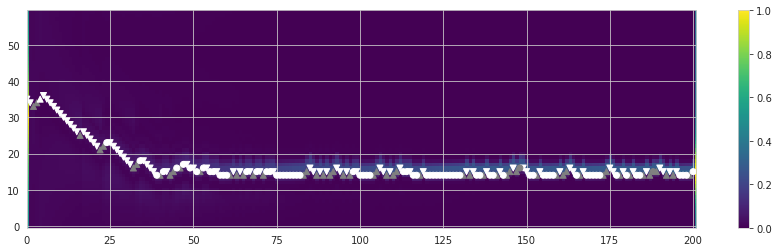

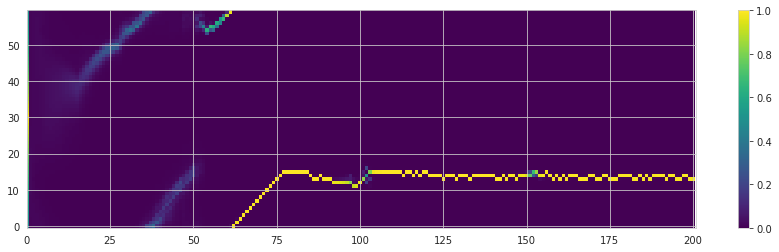

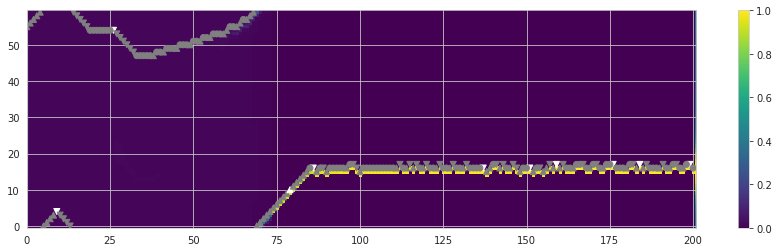

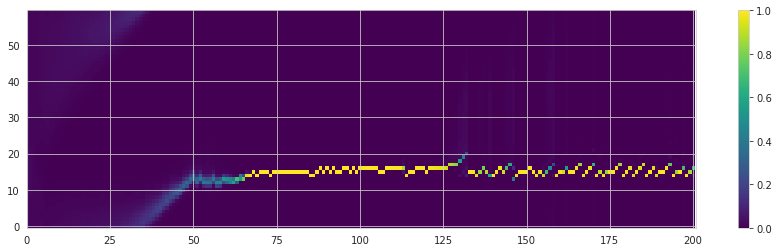

In [ ]:
# single run
MODEL = 4   # <= specify model you want to run
FOOD_POSITION = 15
print(FOOD_POSITION)
t1, c1, b1, psi1, t2, c2, b2, psi2 = singleRun(FOOD_POSITION, 
                                               MAX_SENSE_PROBABILITY,
                                               CONDITIONS[MODEL]['tom'], 
                                               CONDITIONS[MODEL]['alignment'], plot=True)

### Run All Conditions

In [ ]:
# Run All Experimental Conditions
for i in range(1, 5):
  model, t_composite, c_composite, b_composite, fedf = simulateRuns(model = i, no_of_cycles = 3)
  # writing results requires mounting gDrive (function below)
  writeResults('AIF_60_Results', model, t_composite, c_composite, b_composite, fedf)

Running model: 1
 > Env Size: 60
 > Perceptiveness: [0.99, 0.05]
 > ToM: [0, 0]
 > Alignment: 0
Starting Simulation Runs: 180
 > Start Time = 01:35:50
   run: 0
   run: 10
   run: 20
   run: 30
   run: 40
   run: 50
   run: 60
   run: 70
   run: 80
   run: 90
   run: 100
   run: 110
   run: 120
   run: 130
   run: 140
   run: 150
   run: 160
   run: 170
 > End Time = 01:54:41
Simulation Complete for Model: 1


AttributeError: ignored

## Keep Data

### Write Data to GSheets

In [ ]:
!pip install gsheets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# load gsheet library for reading and writing sim results
from google.colab import drive
drive.mount('/content/drive')
import sys
path_to_my_drive_folder = "/content/drive/MyDrive/Colab Notebooks" 
sys.path.append(path_to_my_drive_folder)
import gsheets as gs

# write to gsheets
def writeResults(results_sheet, model, t_composite, c_composite, b_composite, fedf):
  
  Mx = 'M' + str(model)
  tabs = [Mx + '_Targets', Mx + '_Convergence', Mx + '_Belief', Mx + '_FE']

  t_composite.index.name = 'ID'
  gs.writeDfToGSheetTab(results_sheet, tabs[0], t_composite)

  c_composite.index.name = 'ID'
  gs.writeDfToGSheetTab(results_sheet, tabs[1], c_composite)

  b_composite.index.name = 'ID'
  gs.writeDfToGSheetTab(results_sheet, tabs[2], b_composite)

  fedf.index.name = 'Time'
  gs.writeDfToGSheetTab(results_sheet, tabs[3], fedf)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Plot from GSheet

In [ ]:
plot_for_model = 1 # <= Enter model number for plotting here
results_sheet = 'AIF_60_Results'
Mx = 'M' + str(plot_for_model)
tabs = [Mx + '_Targets', Mx + '_Convergence', Mx + '_Belief', Mx + '_FE']

In [ ]:
t = gs.readDfFromGSheetTab(results_sheet, tabs[0]).set_index('ID')
t = t.apply(pd.to_numeric, errors='ignore')
t.groupby('Agent')['Target'].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'

AttributeError: ignored

In [ ]:
c = gs.readDfFromGSheetTab(results_sheet, tabs[1]).set_index('ID')
c = c.apply(pd.to_numeric, errors='ignore')
g = sns.lineplot(data=c, x="Time", y="Distance from Target", hue='Agent', linewidth=2)
g.set_xlim(0,EPOCHS)
g.set_ylim(0)

In [ ]:
b = gs.readDfFromGSheetTab(results_sheet, tabs[2]).set_index('ID')
b = b.apply(pd.to_numeric, errors='ignore')
g = sns.lineplot(data=b, x="Relative Location", y="Belief", hue='Agent', linewidth=2)
g.set_xlim(0, ENV_SIZE-1)
g.set_ylim(0)

## Scratch Pad
- Alternative for specifying goal alignment parameter

In [ ]:
shared_target = 30

target_0 = (shared_target - TARGET_DELTA) % ENV_SIZE
target_1 = (shared_target + TARGET_DELTA) % ENV_SIZE

b_star_0 = initialize_b_star([shared_target, target_0, target_1], 10)
b_star_1 = initialize_b_star([shared_target, target_1, target_0], 10)

ALIGNMENT = 1

# # parametrized logic (general version -- will need updating based on .append/+= in initialize b*)
# B_STARS_ = (B_STARS[0] + ALIGNMENT * (np.minimum(B_STARS[0], B_STARS[1]) - B_STARS[0]),
#             B_STARS[1] + ALIGNMENT * (np.minimum(B_STARS[0], B_STARS[1]) - B_STARS[1]))

# newer bool logic (works only with explicit shared targets)
B_STARS_NEW = (b_star_0[0] + (1 - ALIGNMENT) * b_star_0[1],
               b_star_0[0] + (1 - ALIGNMENT) * b_star_0[2])

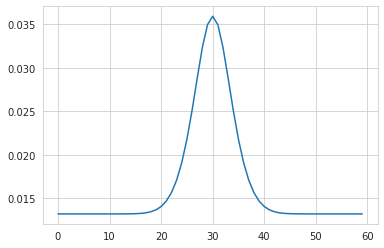

In [ ]:
sns.lineplot(x=range(0, ENV_SIZE), y=model_encoding(B_STARS_NEW[0]))  # initialized b* without alignment modification